<a href="https://colab.research.google.com/github/ELiTE0005/DeepLearningTechniques/blob/main/EXP_8_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4231 - mse: 0.4231 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - lo

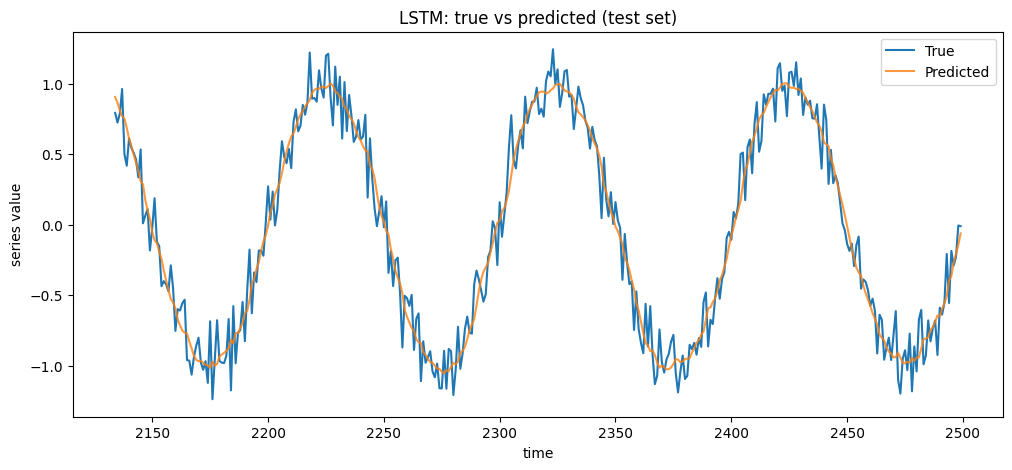

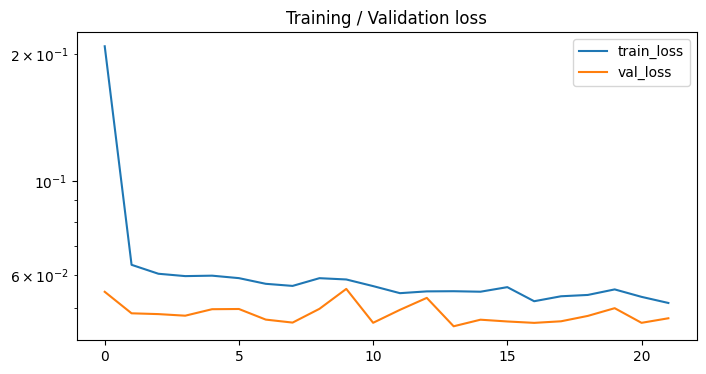

In [1]:
# LSTM-sine-experiment.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1) generate synthetic noisy sine wave
def generate_sine(n_samples=2000, noise_std=0.1, freq=0.02, seed=1):
    rng = np.random.RandomState(seed)
    t = np.arange(n_samples)
    sine = np.sin(2 * np.pi * freq * t)
    noise = rng.normal(scale=noise_std, size=n_samples)
    return t, sine + noise

# 2) prepare supervised sequences (sliding window)
def make_sequences(series, window_size=50):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    X = np.array(X)
    y = np.array(y)
    # reshape for LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# 3) create data
n = 2500
t, series = generate_sine(n_samples=n, noise_std=0.15, freq=0.01, seed=42)
window = 60
X, y = make_sequences(series, window_size=window)

# 4) train/val/test split
train_frac = 0.7
val_frac = 0.15
n_samples = X.shape[0]
i_train = int(n_samples * train_frac)
i_val = int(n_samples * (train_frac + val_frac))

X_train, y_train = X[:i_train], y[:i_train]
X_val, y_val = X[i_train:i_val], y[i_train:i_val]
X_test, y_test = X[i_val:], y[i_val:]

# 5) scale (fit scaler on training target & optionally inputs)
scaler_x = StandardScaler()
# Flatten time dimension to fit scaler then reshape back
X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_train_flat = scaler_x.fit_transform(X_train_flat)
X_train = X_train_flat.reshape((X_train.shape[0], X_train.shape[1], 1))

X_val_flat = X_val.reshape((X_val.shape[0], X_val.shape[1]))
X_val_flat = scaler_x.transform(X_val_flat)
X_val = X_val_flat.reshape((X_val.shape[0], X_val.shape[1], 1))

X_test_flat = X_test.reshape((X_test.shape[0], X_test.shape[1]))
X_test_flat = scaler_x.transform(X_test_flat)
X_test = X_test_flat.reshape((X_test.shape[0], X_test.shape[1], 1))

# scale targets
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# 6) build a small LSTM model
model = Sequential([
    LSTM(64, input_shape=(window, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

# 7) train
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# 8) evaluate & predict on test set
y_pred_test = model.predict(X_test).ravel()
mse = mean_squared_error(y_test, y_pred_test)
print(f"Test MSE (scaled units): {mse:.5f}")

# invert scaling for plotting
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()
y_pred_inv = scaler_y.inverse_transform(y_pred_test.reshape(-1,1)).ravel()

# create timeline for test set plotting
test_start_idx = window + i_val  # the index in original series where test predictions begin
t_test = t[test_start_idx : test_start_idx + len(y_test_inv)]

# 9) plot results
plt.figure(figsize=(12,5))
plt.plot(t[test_start_idx: test_start_idx + len(y_test_inv)], y_test_inv, label='True')
plt.plot(t[test_start_idx: test_start_idx + len(y_test_inv)], y_pred_inv, label='Predicted', alpha=0.8)
plt.title('LSTM: true vs predicted (test set)')
plt.xlabel('time')
plt.ylabel('series value')
plt.legend()
plt.show()

# 10) optional: look at training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.title('Training / Validation loss')
plt.show()
